In [1]:
import requests
import os
import time
import base64
import json
import numpy as np
import matplotlib.pyplot as plt
import cv2 
from PIL import Image

In [2]:
def a2b2s(array:np.array):
    return  base64.b64encode(array.tobytes()).decode('utf-8')

def s2b2a(string:str, dtype,shape=(-1,)):
    data = base64.b64decode(string.encode('utf-8'))
    return np.frombuffer(data, dtype=dtype).reshape(shape)


In [12]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

In [3]:
url = "http://202.204.62.213:11108"	# 服务器的IP

# for img in file_dirs:
# read image
img_path = './notebooks/images/dog.jpg'
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

In [4]:
# encodeimge
img_encode = cv2.imencode(".jpg", image)[1]

data = {'img':a2b2s(img_encode),'flag':1}	# 构建发送格式

In [5]:
r = requests.post(url, data=data)	# 发送，并获取返回的结果
r.status_code == 200

True

In [6]:
dict_res = json.loads(r.text.replace("'",'"'))

dict_res

{'flag': 1, 'time_used': 455.6325988769531}

In [7]:
point_coords = np.array([[500, 375]],dtype=np.int32)
point_labels = np.array([1],dtype=np.bool8)
input_box = np.array([425, 600, 700, 875])
multimask_output = 1

In [8]:
data = {
    "flag":2,
    "point_coords":a2b2s(point_coords), 
    'point_labels':a2b2s(point_labels),
    'multimask_output':str(multimask_output),
}

In [9]:
r = requests.post(url, data=data)	# 发送，并获取返回的结果
r.status_code == 200

True

In [10]:
dict_res = json.loads(r.text.replace("'",'"'))

In [11]:
flag = dict_res['flag']
str_masks = dict_res['masks']
masks = s2b2a(str_masks,dtype=np.uint8,shape=(3,534,800))
str_scores = dict_res['masks']
scores = s2b2a(str_scores,dtype=np.float32,shape=(-1))
str_logits = dict_res['logits']
logits = s2b2a(str_logits,dtype=np.float32,shape=(3,256,256))
time_used = dict_res['time_used']

In [15]:
time_used

21.833023071289062

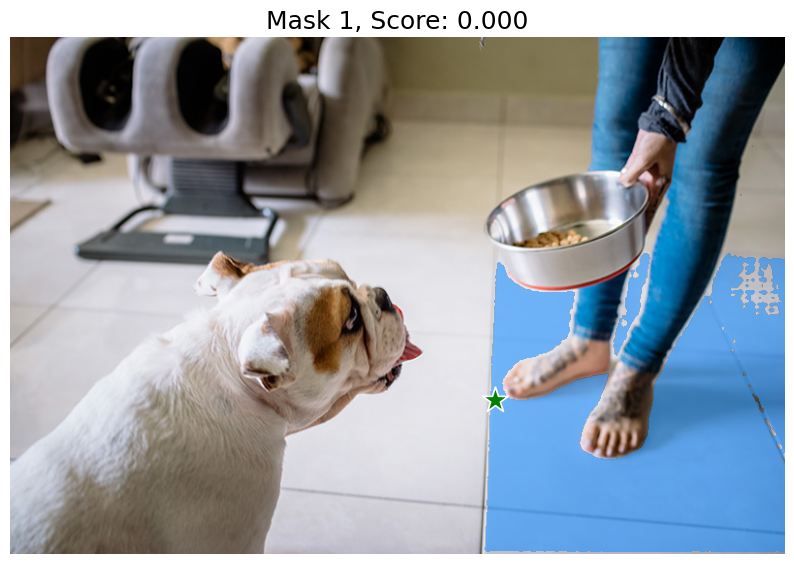

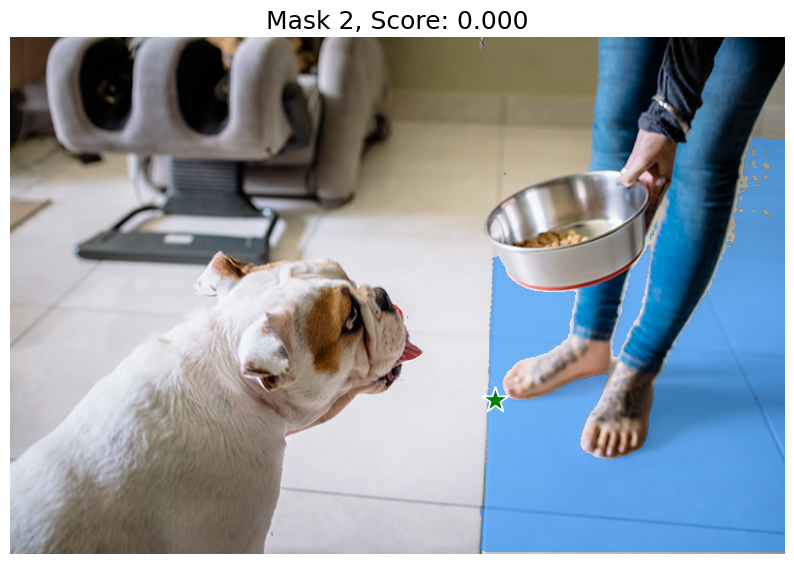

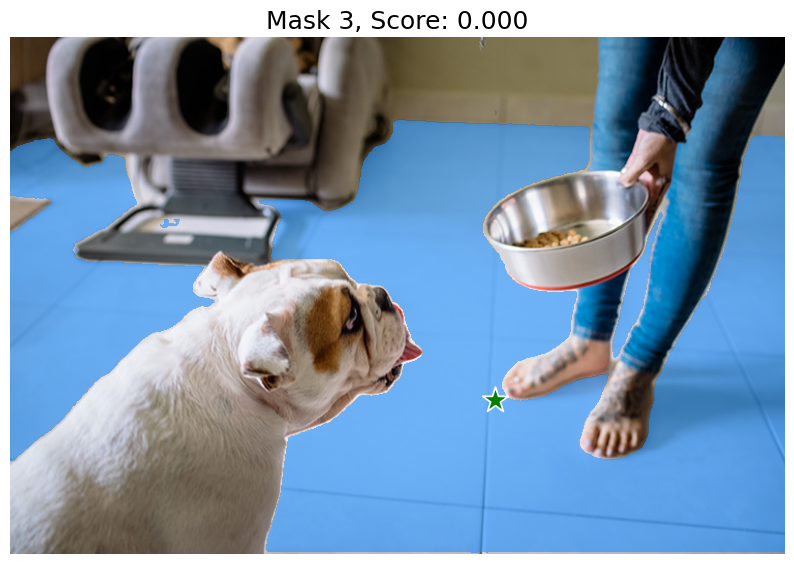

In [14]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(point_coords, point_labels, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  